In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import joblib
import os

# Machine Learning imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Model evaluation and tuning
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           precision_recall_curve, roc_curve, auc, accuracy_score,
                           precision_score, recall_score, f1_score, average_precision_score)

# Additional utilities
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
import shap

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# Set up plotting configuration
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Create directories
os.makedirs('../models', exist_ok=True)
os.makedirs('../images', exist_ok=True)
os.makedirs('../results', exist_ok=True)


### Loading Processed Dataset

In [23]:
print("\nSTEP 1: LOADING PROCESSED DATA")
print("-" * 40)

# Load the processed datasets
try:
    # Load the full processed dataset and recreate the split properly
    df_processed = pd.read_csv('../processed_data/processed_churn_data.csv')
    
    print("Analyzing processed dataset...")
    print(f"   • Dataset shape: {df_processed.shape}")
    print(f"   • Column types: {df_processed.dtypes.value_counts().to_dict()}")
    
    # Identify and remove problematic columns
    categorical_cols_to_remove = ['customerID', 'TenureGroup', 'ChargesGroup', 'CustomerSegment']
    columns_to_remove = [col for col in categorical_cols_to_remove if col in df_processed.columns]
    
    if columns_to_remove:
        print(f"Removing categorical columns: {columns_to_remove}")
        df_processed = df_processed.drop(columns=columns_to_remove)
    
    # Ensure all remaining columns are numeric (except target)
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    object_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"Object columns: {object_cols}")
    
    # Handle any remaining object columns (except Churn)
    if object_cols:
        for col in object_cols:
            if col != 'Churn':
                print(f"Converting {col} to numeric...")
                df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    
    # Prepare features and target
    X = df_processed.drop('Churn', axis=1)
    y = df_processed['Churn']
    
    # Ensure target is numeric
    if y.dtype == 'object':
        print("Converting target to numeric...")
        y = y.map({'No': 0, 'Yes': 1})
    
    # Handle any remaining missing values
    missing_cols = X.columns[X.isnull().any()].tolist()
    if missing_cols:
        print(f"Filling missing values in: {missing_cols}")
        X = X.fillna(X.median())
    
    # Recreate train-validation split with same random state as preprocessing
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    feature_names = X_train.columns.tolist()
    
    print("Datasets prepared successfully!")
    print(f"   • Training set: {X_train.shape}")
    print(f"   • Validation set: {X_val.shape}")
    print(f"   • Features: {len(feature_names)}")
    print(f"   • All features are numeric: {X_train.select_dtypes(include=[np.number]).shape[1] == X_train.shape[1]}")
    print(f"   • Training churn rate: {y_train.mean():.1%}")
    print(f"   • Validation churn rate: {y_val.mean():.1%}")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure you've run 03_preprocessing_feature_engineering.ipynb first")
    raise


STEP 1: LOADING PROCESSED DATA
----------------------------------------
Analyzing processed dataset...
   • Dataset shape: (7043, 43)
   • Column types: {dtype('bool'): 21, dtype('int64'): 12, dtype('float64'): 6, dtype('O'): 4}
Removing categorical columns: ['customerID', 'TenureGroup', 'ChargesGroup', 'CustomerSegment']
Numeric columns: 18
Object columns: []
Datasets prepared successfully!
   • Training set: (5634, 38)
   • Validation set: (1409, 38)
   • Features: 38
   • All features are numeric: False
   • Training churn rate: 26.5%
   • Validation churn rate: 26.5%


### Model Setup

In [25]:
print("\nSTEP 2: MODEL SETUP & BASELINE")
print("-" * 35)

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000),
    'Naive Bayes': GaussianNB()
}

print(f"Models to evaluate: {len(models)}")
for i, model_name in enumerate(models.keys(), 1):
    print(f"   {i}. {model_name}")

# Create baseline prediction (majority class)
baseline_accuracy = max(y_train.mean(), 1 - y_train.mean())
print(f"\nBaseline Performance:")
print(f"   • Majority class accuracy: {baseline_accuracy:.1%}")
print(f"   • Random guess accuracy: ~50%")
print(f"   • Target: Beat {baseline_accuracy:.1%} significantly")


STEP 2: MODEL SETUP & BASELINE
-----------------------------------
Models to evaluate: 6
   1. Logistic Regression
   2. Random Forest
   3. Gradient Boosting
   4. SVM
   5. Neural Network
   6. Naive Bayes

Baseline Performance:
   • Majority class accuracy: 73.5%
   • Random guess accuracy: ~50%
   • Target: Beat 73.5% significantly


### Model Training

In [26]:
print("\nSTEP 3: INITIAL MODEL TRAINING")
print("-" * 35)

# Dictionary to store results
results = {}
trained_models = {}

print("Training models...")
for model_name, model in models.items():
    print(f"   Training {model_name}...")
    
    # Train model
    model.fit(X_train, y_train)
    trained_models[model_name] = model
    
    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    pr_auc = average_precision_score(y_val, y_pred_proba)
    
    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

print("Initial training complete!")


STEP 3: INITIAL MODEL TRAINING
-----------------------------------
Training models...
   Training Logistic Regression...
   Training Random Forest...
   Training Gradient Boosting...
   Training SVM...
   Training Neural Network...
   Training Naive Bayes...
Initial training complete!


### Performance Comparison

In [27]:
print("\nSTEP 4: MODEL PERFORMANCE COMPARISON")
print("-" * 45)

# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.drop(['y_pred', 'y_pred_proba'], axis=1)
results_df = results_df.round(4)

print("Model Performance Summary:")
print("=" * 70)
print(results_df.to_string())

# Find best model for each metric
best_models = {}
for metric in results_df.columns:
    best_model = results_df[metric].idxmax()
    best_score = results_df[metric].max()
    best_models[metric] = {'model': best_model, 'score': best_score}
    
print(f"\nBest Models by Metric:")
print("-" * 25)
for metric, info in best_models.items():
    print(f"   • {metric:<12}: {info['model']} ({info['score']:.3f})")

# Overall best model (balanced performance)
results_df['Overall_Score'] = (results_df['F1-Score'] + results_df['ROC-AUC'] + results_df['PR-AUC']) / 3
best_overall = results_df['Overall_Score'].idxmax()
print(f"\nBest Overall Model: {best_overall} (Score: {results_df.loc[best_overall, 'Overall_Score']:.3f})")



STEP 4: MODEL PERFORMANCE COMPARISON
---------------------------------------------
Model Performance Summary:
                     Accuracy Precision    Recall  F1-Score   ROC-AUC    PR-AUC
Logistic Regression  0.811214  0.683673  0.537433  0.601796  0.847309  0.662486
Random Forest        0.779986  0.607383  0.483957   0.53869   0.82515  0.616593
Gradient Boosting    0.802697  0.670213  0.505348   0.57622   0.84422  0.659241
SVM                  0.799148  0.666667  0.486631  0.562597   0.80282  0.626944
Neural Network       0.765791  0.571429  0.470588  0.516129  0.799191  0.541639
Naive Bayes          0.668559  0.436735  0.858289    0.5789  0.803348  0.573847

Best Models by Metric:
-------------------------
   • Accuracy    : Logistic Regression (0.811)
   • Precision   : Logistic Regression (0.684)
   • Recall      : Naive Bayes (0.858)
   • F1-Score    : Logistic Regression (0.602)
   • ROC-AUC     : Logistic Regression (0.847)
   • PR-AUC      : Logistic Regression (0.662)

Best

### Visualization


STEP 5: MODEL COMPARISON VISUALIZATIONS
---------------------------------------------


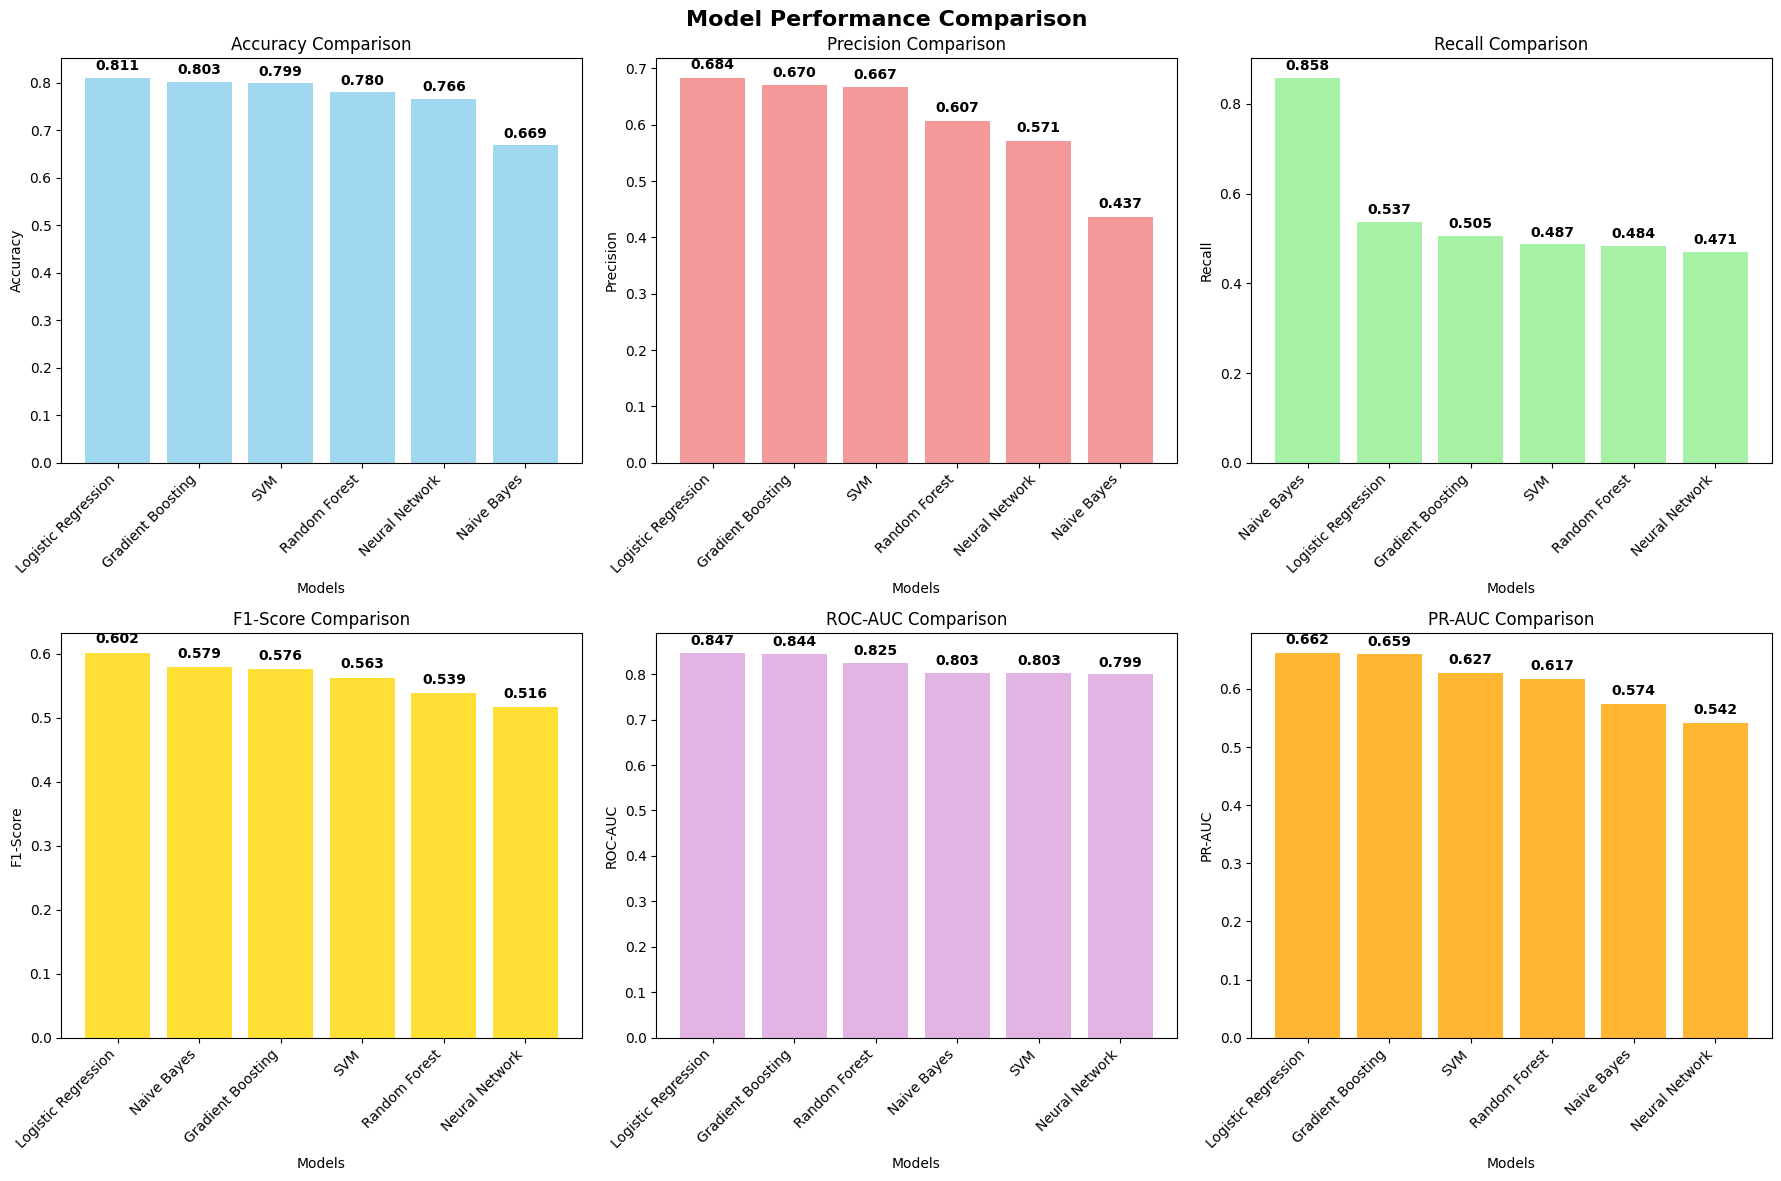

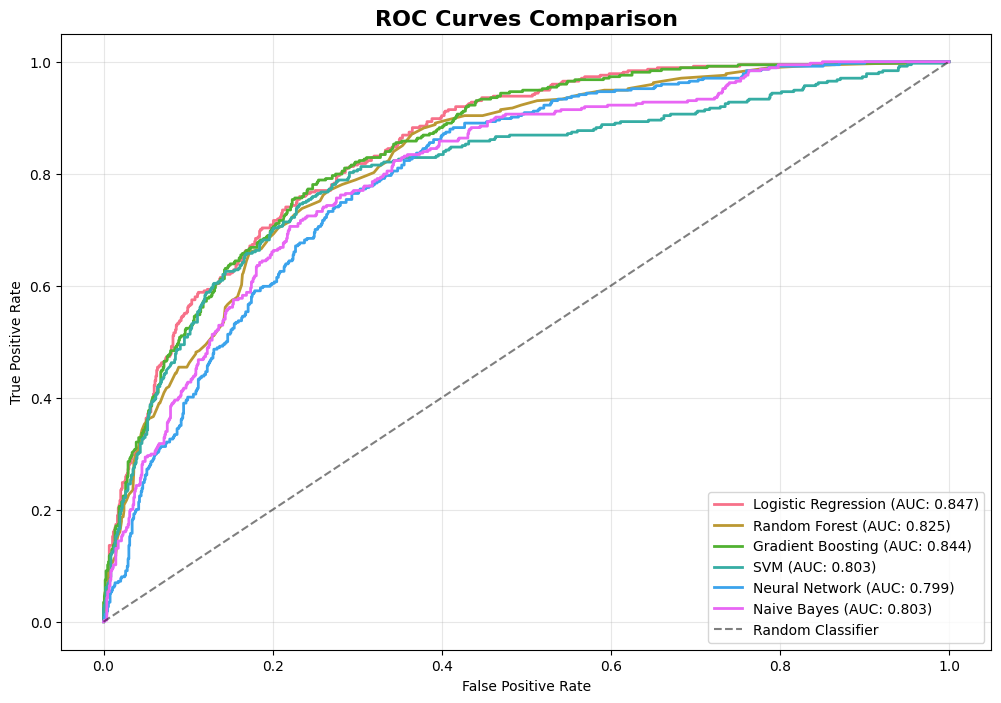

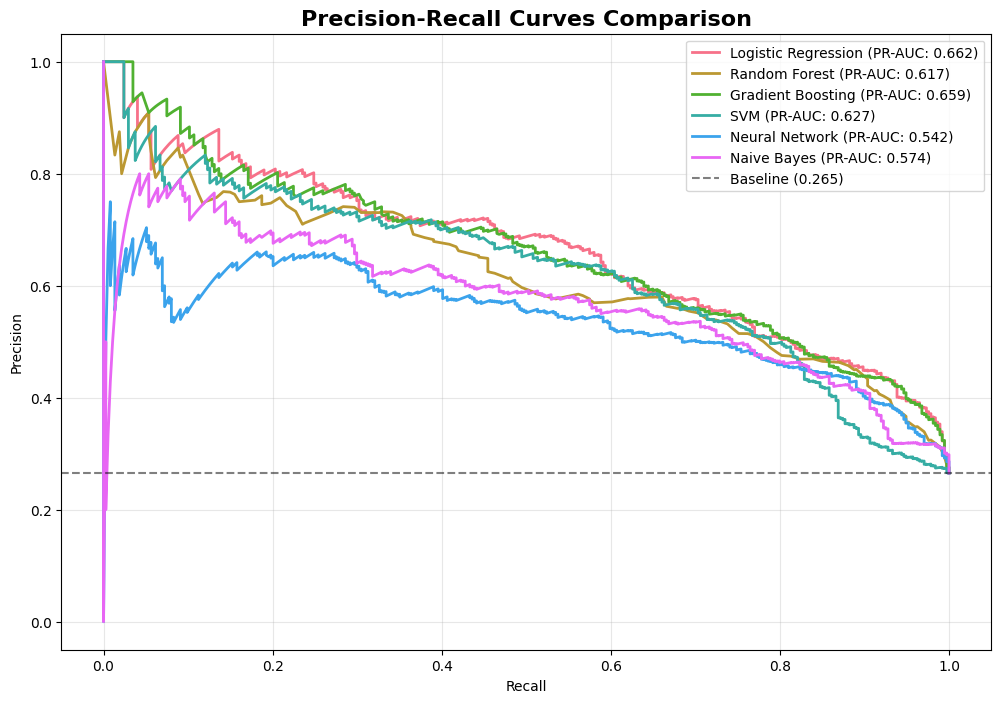

In [28]:
print("\nSTEP 5: MODEL COMPARISON VISUALIZATIONS")
print("-" * 45)

# 1. Performance metrics comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'orange']

for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    
    metric_scores = results_df[metric].sort_values(ascending=False)
    bars = ax.bar(range(len(metric_scores)), metric_scores.values, color=colors[i], alpha=0.8)
    
    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('Models')
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(metric_scores)))
    ax.set_xticklabels(metric_scores.index, rotation=45, ha='right')
    
    # Add value labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../images/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. ROC Curves comparison
plt.figure(figsize=(12, 8))
for model_name in models.keys():
    y_pred_proba = results[model_name]['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    auc_score = roc_auc_score(y_val, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC: {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../images/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Precision-Recall Curves comparison
plt.figure(figsize=(12, 8))
for model_name in models.keys():
    y_pred_proba = results[model_name]['y_pred_proba']
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    pr_auc = average_precision_score(y_val, y_pred_proba)
    plt.plot(recall, precision, label=f'{model_name} (PR-AUC: {pr_auc:.3f})', linewidth=2)

plt.axhline(y=y_val.mean(), color='k', linestyle='--', alpha=0.5, label=f'Baseline ({y_val.mean():.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Comparison', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../images/precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()


### Hyperparameter Tuning

In [29]:
print(f"\nSTEP 6: HYPERPARAMETER TUNING - {best_overall}")
print("-" * 50)

# Define parameter grids for top models
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
}

# Perform hyperparameter tuning for the best model
if best_overall in param_grids:
    print(f"Tuning {best_overall}...")
    
    # Set up cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Grid search
    grid_search = GridSearchCV(
        models[best_overall], 
        param_grids[best_overall],
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    print("Running grid search...")
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_tuned_model = grid_search.best_estimator_
    print(f"Best parameters found:")
    for param, value in grid_search.best_params_.items():
        print(f"   • {param}: {value}")
    
    # Evaluate tuned model
    y_pred_tuned = best_tuned_model.predict(X_val)
    y_pred_proba_tuned = best_tuned_model.predict_proba(X_val)[:, 1]
    
    tuned_f1 = f1_score(y_val, y_pred_tuned)
    tuned_roc_auc = roc_auc_score(y_val, y_pred_proba_tuned)
    
    print(f"\nPerformance Improvement:")
    print(f"   • Original F1-Score: {results[best_overall]['F1-Score']:.3f}")
    print(f"   • Tuned F1-Score: {tuned_f1:.3f}")
    print(f"   • Improvement: {tuned_f1 - results[best_overall]['F1-Score']:.3f}")
    
    # Update best model
    final_model = best_tuned_model
    final_predictions = y_pred_tuned
    final_probabilities = y_pred_proba_tuned
    
else:
    print(f"Using original {best_overall} model")
    final_model = trained_models[best_overall]
    final_predictions = results[best_overall]['y_pred']
    final_probabilities = results[best_overall]['y_pred_proba']


STEP 6: HYPERPARAMETER TUNING - Logistic Regression
--------------------------------------------------
Tuning Logistic Regression...
Running grid search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:
   • C: 100
   • penalty: l1
   • solver: saga

Performance Improvement:
   • Original F1-Score: 0.602
   • Tuned F1-Score: 0.596
   • Improvement: -0.005


### Detailed Analysis


STEP 7: DETAILED ANALYSIS - Logistic Regression
----------------------------------------
Confusion Matrix:
[[936  99]
 [173 201]]

Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.90      0.87      1035
       Churn       0.67      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



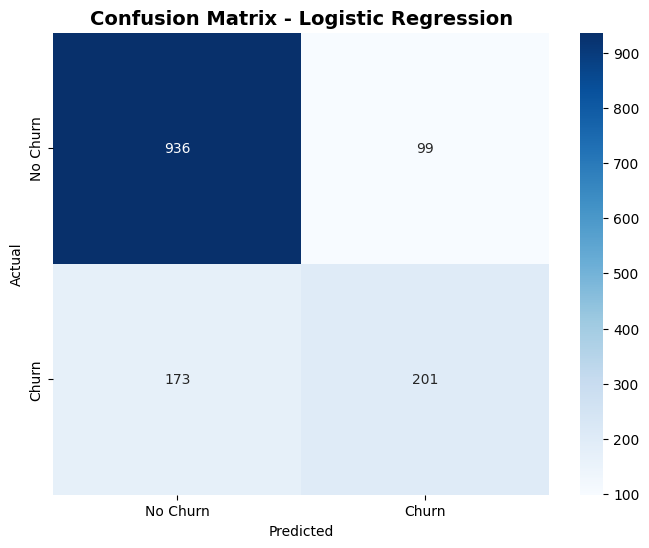

In [30]:
print(f"\nSTEP 7: DETAILED ANALYSIS - {best_overall}")
print("-" * 40)

# Confusion Matrix
cm = confusion_matrix(y_val, final_predictions)
print("Confusion Matrix:")
print(cm)

# Classification Report
print(f"\nDetailed Classification Report:")
print(classification_report(y_val, final_predictions, target_names=['No Churn', 'Churn']))

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_overall}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../images/confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

### Analysis of importance of feature

In [31]:
print("\nSTEP 8: FEATURE IMPORTANCE ANALYSIS")
print("-" * 42)

# Get feature importance based on model type
if hasattr(final_model, 'feature_importances_'):
    # Tree-based models
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    print("-" * 35)
    for i, (_, row) in enumerate(feature_importance.head(15).iterrows(), 1):
        print(f"   {i:2d}. {row['Feature']:<25}: {row['Importance']:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue', alpha=0.8)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importances - {best_overall}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('../images/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

elif hasattr(final_model, 'coef_'):
    # Linear models
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': final_model.coef_[0],
        'Abs_Coefficient': np.abs(final_model.coef_[0])
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("Top 15 Most Important Features (by |coefficient|):")
    print("-" * 50)
    for i, (_, row) in enumerate(feature_importance.head(15).iterrows(), 1):
        direction = "↑" if row['Coefficient'] > 0 else "↓"
        print(f"   {i:2d}. {row['Feature']:<25}: {row['Coefficient']:>7.4f} {direction}")



STEP 8: FEATURE IMPORTANCE ANALYSIS
------------------------------------------
Top 15 Most Important Features (by |coefficient|):
--------------------------------------------------
    1. TotalCharges             :  3.8020 ↑
    2. CustomerLifetimeValue    : -3.3692 ↓
    3. InternetService_Fiber optic:  2.9823 ↑
    4. Contract_Two year        : -1.6018 ↓
    5. MonthlyCharges           : -1.5277 ↓
    6. TotalServices            :  1.4878 ↑
    7. AvgChargesPerMonth       : -1.2634 ↓
    8. tenure                   : -0.8719 ↓
    9. MultipleLines_No phone service: -0.7929 ↓
   10. Contract_One year        : -0.7611 ↓
   11. OnlineSecurity_Yes       : -0.5835 ↓
   12. TechSupport_Yes          : -0.5230 ↓
   13. StreamingMovies_Yes      :  0.4969 ↑
   14. StreamingTV_Yes          :  0.4912 ↑
   15. PaperlessBilling         : -0.3723 ↓


### Analysis of impact on business

In [32]:
print("\nSTEP 9: BUSINESS IMPACT ANALYSIS")
print("-" * 38)

# Define business costs (example values - adjust based on real business)
cost_acquire_customer = 100  # Cost to acquire a new customer
value_retained_customer = 500  # Value of retaining a customer for a year
cost_retention_campaign = 50   # Cost of retention campaign per customer

# Calculate business metrics
tn, fp, fn, tp = cm.ravel()

# Business scenarios
total_customers = len(y_val)
actual_churners = (y_val == 1).sum()
predicted_churners = (final_predictions == 1).sum()

print(f"Business Scenario Analysis:")
print(f"   • Total customers in validation: {total_customers:,}")
print(f"   • Actual churners: {actual_churners:,} ({actual_churners/total_customers:.1%})")
print(f"   • Predicted churners: {predicted_churners:,} ({predicted_churners/total_customers:.1%})")

# Cost-Benefit Analysis
print(f"\nModel Business Impact:")
print("-" * 25)

# Without model (do nothing)
cost_without_model = actual_churners * cost_acquire_customer
print(f"   • Cost without model (lost customers): ${cost_without_model:,}")

# With model
# True Positives: Correctly identified churners we can save
revenue_saved = tp * (value_retained_customer - cost_retention_campaign)
# False Positives: Unnecessary retention campaigns  
wasted_campaigns = fp * cost_retention_campaign
# False Negatives: Churners we missed
missed_opportunities = fn * cost_acquire_customer

net_benefit = revenue_saved - wasted_campaigns - missed_opportunities
total_cost_with_model = wasted_campaigns + missed_opportunities

print(f"   • Revenue from saved customers (TP): ${revenue_saved:,}")
print(f"   • Cost of unnecessary campaigns (FP): ${wasted_campaigns:,}")
print(f"   • Cost of missed churners (FN): ${missed_opportunities:,}")
print(f"   • Total cost with model: ${total_cost_with_model:,}")
print(f"   • Net benefit: ${net_benefit:,}")
print(f"   • ROI: {(net_benefit / max(total_cost_with_model, 1)) * 100:.1f}%")

savings = cost_without_model - total_cost_with_model
print(f"\nBottom Line: ${savings:,} saved vs doing nothing!")



STEP 9: BUSINESS IMPACT ANALYSIS
--------------------------------------
Business Scenario Analysis:
   • Total customers in validation: 1,409
   • Actual churners: 374 (26.5%)
   • Predicted churners: 300 (21.3%)

Model Business Impact:
-------------------------
   • Cost without model (lost customers): $37,400
   • Revenue from saved customers (TP): $90,450
   • Cost of unnecessary campaigns (FP): $4,950
   • Cost of missed churners (FN): $17,300
   • Total cost with model: $22,250
   • Net benefit: $68,200
   • ROI: 306.5%

Bottom Line: $15,150 saved vs doing nothing!


### Model Deployment Prep

In [33]:
print("\nSTEP 10: MODEL DEPLOYMENT PREPARATION")
print("-" * 45)

# Save the best model
model_filename = f'../models/best_churn_model_{best_overall.lower().replace(" ", "_")}.pkl'
joblib.dump(final_model, model_filename)
print(f"Model saved: {model_filename}")

# Save feature names and preprocessing info
deployment_info = {
    'model_name': best_overall,
    'features': feature_names,
    'feature_count': len(feature_names),
    'training_date': datetime.now().strftime('%Y-%m-%d'),
    'performance_metrics': {
        'accuracy': accuracy_score(y_val, final_predictions),
        'precision': precision_score(y_val, final_predictions),
        'recall': recall_score(y_val, final_predictions),
        'f1_score': f1_score(y_val, final_predictions),
        'roc_auc': roc_auc_score(y_val, final_probabilities)
    }
}

# Save deployment info
import json
with open('../models/model_deployment_info.json', 'w') as f:
    json.dump(deployment_info, f, indent=4, default=str)

print("Deployment info saved: model_deployment_info.json")

# Create prediction function template
prediction_template = f'''
def predict_churn(customer_data):
    """
    Predict customer churn probability
    
    Parameters:
    customer_data: dict or DataFrame with features: {feature_names[:5]}... (total: {len(feature_names)})
    
    Returns:
    probability: float (0-1) - probability of churn
    prediction: int (0/1) - binary prediction
    """
    import joblib
    import pandas as pd
    
    model = joblib.load('best_churn_model_{best_overall.lower().replace(" ", "_")}.pkl')
    
    if isinstance(customer_data, dict):
        customer_data = pd.DataFrame([customer_data])
    
    probability = model.predict_proba(customer_data)[0][1]
    prediction = model.predict(customer_data)[0]
    
    return {{
        'churn_probability': probability,
        'will_churn': bool(prediction),
        'risk_level': 'High' if probability > 0.7 else 'Medium' if probability > 0.3 else 'Low'
    }}
'''

with open('../models/prediction_template.py', 'w') as f:
    f.write(prediction_template)

print("Prediction template saved: prediction_template.py")


STEP 10: MODEL DEPLOYMENT PREPARATION
---------------------------------------------
Model saved: ../models/best_churn_model_logistic_regression.pkl
Deployment info saved: model_deployment_info.json
Prediction template saved: prediction_template.py


### Summary

In [36]:
print("\nFINAL SUMMARY")
print("-" * 45)

print(f"BEST MODEL: {best_overall}")
print("=" * 50)
print(f"Performance Metrics:")
print(f"   - Accuracy: {accuracy_score(y_val, final_predictions):.1%}")
print(f"   - Precision: {precision_score(y_val, final_predictions):.1%}")
print(f"   - Recall: {recall_score(y_val, final_predictions):.1%}")
print(f"   - F1-Score: {f1_score(y_val, final_predictions):.3f}")
print(f"   - ROC-AUC: {roc_auc_score(y_val, final_probabilities):.3f}")

print(f"\nBusiness Impact:")
print(f"   - Estimated savings: ${savings:,}")
print(f"   - ROI: {(net_benefit / max(total_cost_with_model, 1)) * 100:.1f}%")
print(f"   - Customers saved: {tp} out of {actual_churners}")

print(f"\nKey Insights:")
if hasattr(final_model, 'feature_importances_'):
    top_3_features = feature_importance.head(3)['Feature'].tolist()
    print(f"   - Top churn predictors: {', '.join(top_3_features)}")
print(f"   - Model can identify {recall_score(y_val, final_predictions):.1%} of churners")
print(f"   - {precision_score(y_val, final_predictions):.1%} of predicted churners actually churn")



FINAL SUMMARY
---------------------------------------------
BEST MODEL: Logistic Regression
Performance Metrics:
   - Accuracy: 80.7%
   - Precision: 67.0%
   - Recall: 53.7%
   - F1-Score: 0.596
   - ROC-AUC: 0.846

Business Impact:
   - Estimated savings: $15,150
   - ROI: 306.5%
   - Customers saved: 201 out of 374

Key Insights:
   - Model can identify 53.7% of churners
   - 67.0% of predicted churners actually churn
